In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray
!pip install pyro-ppl
!pip install torch_geometric

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
import pyro

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/climate-ml-project2-parametrization-group2/Group-2/Project2-Parameterization


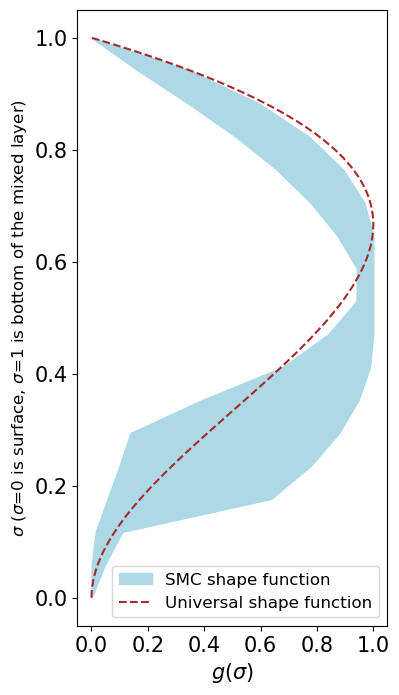

In [3]:
# Load GOTM training data produced by Sane et al. 2023
# Plot the assumed univeral shape function vs. GOTM results to illustrate the qualitative differences

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)

# define vertical coordinate
sig=np.linspace(0,1,18)

# define universal shape function, section 2
# gamma = 2
z=np.linspace(0,1,100)
z1=z*(1-z)**2
z1=z1/np.max(z1)

sfmin=np.zeros(18)
sfmax=np.zeros(18)
sfmin[1:17]=np.min(sf,axis=0)
sfmax[1:17]=np.max(sf,axis=0)

plt.figure(figsize=(4,8))
#plt.plot(sfmin,sig,'o')
#plt.plot(sfmax,sig,'o')
plt.fill_betweenx(sig,sfmin,sfmax,color='lightblue',label='SMC shape function')
plt.plot(z1[::-1],z,color='brown',linestyle='--',label='Universal shape function')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$g(\sigma)$',fontsize=15)
plt.ylabel(r'$\sigma$ ($\sigma$=0 is surface, $\sigma$=1 is bottom of the mixed layer)',fontsize=12)
plt.legend(fontsize=12)

In [4]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

In [5]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [6]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)  
# Note: ff.preprocess_train_data is a custom function defined in lib/func_file.py that normalizes, log-transforms and shuffles the dataset


started


In [7]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [8]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# Neural Network Architecture

In [9]:
class MRFLearnKappa(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(MRFLearnKappa, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)   # First layer: input to hidden
        self.linear2 = nn.Linear(Hid, Out_nodes)    # Second layer: hidden to output
        self.dropout = nn.Dropout(0.25)             # Dropout for regularization

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        return y_pred

def mrf_loss(g, lambda_mrf=1.0):
    """
    Computes a smoothness penalty for the predicted shape function.
    This term enforces that adjacent vertical nodes should not differ too much,
    reflecting the Markov property (local dependency) in an MRF.
    
    g: Tensor of shape [batch_size, num_nodes]
    lambda_mrf: Weight for the MRF loss term.
    """
    # Compute differences between adjacent nodes along the vertical dimension.
    diff = g[:, 1:] - g[:, :-1]
    # Mean squared difference
    loss = torch.mean(diff ** 2)
    return lambda_mrf * loss


# Model Training

Combine the standard prediction loss (e.g., mean absolute error or L1 loss between the network’s output and the training data) with the MRF loss.

In [11]:
# using Mean Absolute Error as the prediction loss.
criterion = nn.L1Loss()
model = MRFLearnKappa(In_nodes=4, Hid=32, Out_nodes=16)
# model.to('cuda') # include if running on GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 300  
lambda_mrf = 0.1

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Suppose inputs is a tensor with shape [batch_size, 4]
    # and targets is the corresponding ground truth shape function with shape [batch_size, 16].
    outputs = model(x)
    
    loss_pred = criterion(outputs, y)
    loss_smooth = mrf_loss(outputs, lambda_mrf=lambda_mrf)
    total_loss = loss_pred + loss_smooth
    
    total_loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.4f}")


Epoch 0, Total Loss: 0.7987
Epoch 10, Total Loss: 0.7557
Epoch 20, Total Loss: 0.7202
Epoch 30, Total Loss: 0.6907
Epoch 40, Total Loss: 0.6648
Epoch 50, Total Loss: 0.6408
Epoch 60, Total Loss: 0.6172
Epoch 70, Total Loss: 0.5943
Epoch 80, Total Loss: 0.5721
Epoch 90, Total Loss: 0.5511
Epoch 100, Total Loss: 0.5321
Epoch 110, Total Loss: 0.5159
Epoch 120, Total Loss: 0.5025
Epoch 130, Total Loss: 0.4917
Epoch 140, Total Loss: 0.4829
Epoch 150, Total Loss: 0.4756
Epoch 160, Total Loss: 0.4695
Epoch 170, Total Loss: 0.4642
Epoch 180, Total Loss: 0.4593
Epoch 190, Total Loss: 0.4550
Epoch 200, Total Loss: 0.4511
Epoch 210, Total Loss: 0.4475
Epoch 220, Total Loss: 0.4443
Epoch 230, Total Loss: 0.4413
Epoch 240, Total Loss: 0.4384
Epoch 250, Total Loss: 0.4358
Epoch 260, Total Loss: 0.4336
Epoch 270, Total Loss: 0.4312
Epoch 280, Total Loss: 0.4291
Epoch 290, Total Loss: 0.4272


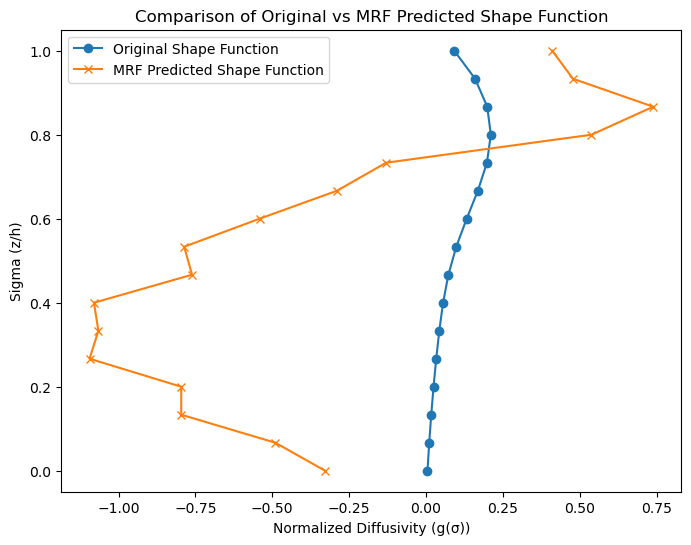

In [17]:
sigma = np.linspace(0, 1, 16)  # sigma goes from 0 (surface) to 1 (depth of the boundary layer)

plt.figure(figsize=(8, 6))
plt.plot(SF0.values[10], sigma, label="Original Shape Function", marker="o")
plt.plot(outputs[10].cpu().detach().numpy(), sigma, label="MRF Predicted Shape Function", marker="x")
plt.ylabel("Sigma (z/h)")
plt.xlabel("Normalized Diffusivity (g(σ))")
plt.title("Comparison of Original vs MRF Predicted Shape Function")
plt.legend()
plt.show()

**Discussion**

Using this combined loss, you’re effectively imposing an MRF-like structure on the network’s output without changing the basic feedforward architecture. This approach is appealing because:

It adds only a modest computational cost.
It allows you to quantify and control smoothness (a property often desirable in vertical profiles).
It provides a way to “regularize” the predictions so that they obey some of the spatial dependencies that a full probabilistic graphical model (or CRF) might capture.
If you want to go even further into a full probabilistic graphical model (e.g., defining explicit distributions over each node and performing inference over a joint distribution), you’d likely need to adopt a Bayesian or CRF framework (for instance, using Pyro or a CRF layer). However, for many practical applications, the smoothness penalty (MRF loss) is a simple and effective way to integrate the idea of local dependency among outputs.

# Trial 2

In [18]:
# Filtering data based on valid parameter ranges
ind1 = np.where(np.abs(heat0) < 601)[0]  # Heat flux constraint
ind2 = np.where(tx0 < 1.2)[0]            # Wind stress constraint
ind3 = np.where(h0 > 29)[0]              # Min boundary layer depth
ind4 = np.where(h0 < 300)[0]             # Max boundary layer depth

valid_indices = np.intersect1d(np.intersect1d(ind1, ind2), np.intersect1d(ind3, ind4))

# Subset filtered data
heat = heat0[valid_indices]
tx = tx0[valid_indices]
h = h0[valid_indices]
SF = SF0[valid_indices]

# Normalize data for stability
depth_levels = np.linspace(0, 1, SF.shape[1])  # Normalized depth (σ)
forcing_parameters = np.vstack((heat, tx, h)).T  # Stack forcing parameters

In [19]:
import numpy as np
import xarray as xr
import networkx as nx
from scipy.optimize import minimize

# Define MRF structure
num_depths = SF.shape[1]
G = nx.Graph()
for i in range(num_depths):
    G.add_node(i)

for i in range(num_depths - 1):
    G.add_edge(i, i + 1)  # Connecting adjacent depths

# Define MRF Energy Function
def energy_function(diffusivity_values, forcing_params, lambda_smooth=0.5):
    unary_potential = np.sum((diffusivity_values - np.exp(-depth_levels * 2))**2)  # Bias toward expected profile
    pairwise_potential = lambda_smooth * np.sum((diffusivity_values[1:] - diffusivity_values[:-1])**2)  # Smoothness term
    return unary_potential + pairwise_potential

# Train MRF using MLE
def train_mrf(forcing_parameters):
    initial_guess = np.random.rand(num_depths)  # Random initialization
    result = minimize(energy_function, initial_guess, args=(forcing_parameters,), method='L-BFGS-B')
    return result.x

# Perform MRF inference
predicted_diffusivity = train_mrf(forcing_parameters)

# Save predicted diffusivity profile
np.save("predicted_diffusivity.npy", predicted_diffusivity)

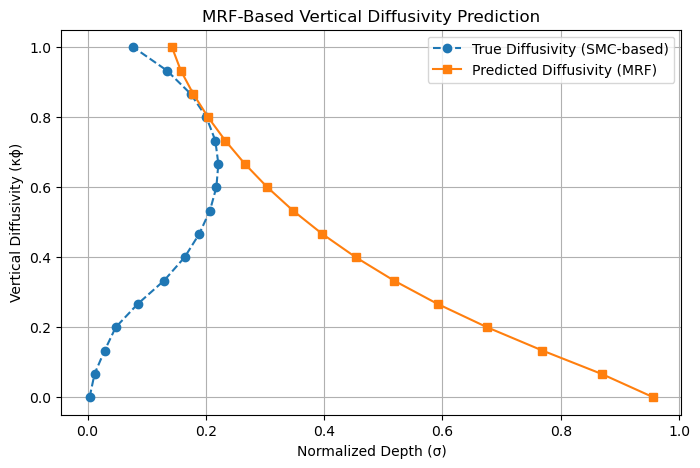

In [21]:
# Define depth levels (normalized from 0 to 1)
num_depths = len(predicted_diffusivity)
depth_levels = np.linspace(0, 1, num_depths)  # Normalized Depth (σ)

true_diffusivity = SF0[valid_indices].mean(axis=0)  # Averaging over valid cases

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(true_diffusivity, depth_levels, label="True Diffusivity (SMC-based)", linestyle="--", marker="o")
plt.plot(predicted_diffusivity, depth_levels, label="Predicted Diffusivity (MRF)", linestyle="-", marker="s")
plt.xlabel("Normalized Depth (σ)")
plt.ylabel("Vertical Diffusivity (κϕ)")
plt.title("MRF-Based Vertical Diffusivity Prediction")
plt.legend()
plt.grid()
plt.show()


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Load dataset (ensure this is available)
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# Load the true shape function from the dataset
SF0 = d['SF'][:]  # This is the true diffusivity profile from the dataset

# Apply filtering
heat0 = d['heat'][:]
tx0 = d['tx'][:]
h0 = d['h'][:]

ind1 = np.where(np.abs(heat0) < 601)[0]
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 300)[0]
valid_indices = np.intersect1d(np.intersect1d(ind1, ind2), np.intersect1d(ind3, ind4))

# Subset true diffusivity
true_diffusivity = SF0[valid_indices].mean(axis=0)

# Define depth levels (normalized from 0 to 1)
num_depths = true_diffusivity.shape[0]
depth_levels = np.linspace(0, 1, num_depths)  # Normalized Depth (σ)

# Define the MRF-based Neural Network
class MRFLearnKappa(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(MRFLearnKappa, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)   # First layer: input to hidden
        self.linear2 = nn.Linear(Hid, Out_nodes)  # Second layer: hidden to output
        self.dropout = nn.Dropout(0.25)           # Dropout for regularization

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        return y_pred

# Define MRF Smoothness Loss
def mrf_loss(g, lambda_mrf=1.0):
    """
    Computes a smoothness penalty for the predicted shape function.
    This term enforces that adjacent vertical nodes should not differ too much,
    reflecting the Markov property (local dependency) in an MRF.
    
    g: Tensor of shape [batch_size, num_nodes]
    lambda_mrf: Weight for the MRF loss term.
    """
    diff = g[:, 1:] - g[:, :-1]
    loss = torch.mean(diff ** 2)
    return lambda_mrf * loss


In [73]:
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [75]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [ ]:
# Prepare Training Data
forcing_parameters = np.vstack((heat0[valid_indices], tx0[valid_indices], h0[valid_indices])).T
X_train = torch.tensor(forcing_parameters, dtype=torch.float32)
# y_train = torch.tensor(true_diffusivity, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension
y_train = torch.tensor(true_diffusivity, dtype=torch.float32)

# Initialize Model
input_dim = X_train.shape[1]  # 3 input features
hidden_dim = 64
output_dim = num_depths
model = MRFLearnKappa(input_dim, hidden_dim, output_dim)

# Define Loss & Optimizer
criterion = nn.MSELoss()  # Standard regression loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 500
lambda_mrf = 0.1  # Adjust weight for smoothness

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward Pass
    y_pred = model(X_train)

    # Compute Loss
    mse_loss = criterion(y_pred, y_train)
    smoothness_loss = mrf_loss(y_pred, lambda_mrf)
    loss = mse_loss + smoothness_loss  # Combined loss

    # Backward Pass & Optimization
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs} - MSE Loss: {mse_loss.item():.4f} - Smoothness Loss: {smoothness_loss.item():.4f}")

# Final Prediction
model.eval()
predicted_diffusivity = model(X_train).detach().numpy().mean(axis=0)  # Averaged across samples

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(depth_levels, true_diffusivity, label="True Diffusivity (SMC Data)", linestyle="--", marker="o")
plt.plot(depth_levels, predicted_diffusivity, label="Predicted Diffusivity (MRF + NN)", linestyle="-", marker="s")
plt.xlabel("Normalized Depth (σ)")
plt.ylabel("Vertical Diffusivity (κϕ)")
plt.title("Improved MRF-Based Vertical Diffusivity Prediction")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# bayesian model

import pyro
import pyro.distributions as dist

class BayesianMLP(nn.Module):
    
    def __init__(self, In_nodes, Hid, Out_nodes):
        super().__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)
        self.linear2 = nn.Linear(Hid, Out_nodes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Deterministic forward
        hidden = torch.relu(self.linear1(x))
        hidden = self.dropout(hidden)
        mean = self.linear2(hidden)  # This could be the mean of your distribution

        # For demonstration, assume a fixed std
        std = torch.exp(torch.zeros_like(mean))  # e.g., std=1.0

        # Return a distribution object (Normal in this case)
        return dist.Normal(mean, std)